<a href="https://colab.research.google.com/github/violetcfelt/oceanfronts/blob/main/AnalyzingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Conv2DTranspose
from tensorflow.keras import Model
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
def custom_loss(logits, label, name='cross_entropy_loss'):
    """
    Implements Equation [2] in https://arxiv.org/pdf/1504.06375.pdf
    Compute edge pixels for each training sample and set as pos_weights to
    tf.nn.weighted_cross_entropy_with_logits
    """
    y = tf.cast(label, tf.float32)

    count_neg = tf.reduce_sum(1. - y)
    count_pos = tf.reduce_sum(y)

    beta = count_neg / (count_neg + count_pos)

    pos_weight = beta / (1 - beta)

    cost = tf.nn.weighted_cross_entropy_with_logits(logits=logits, labels=y, pos_weight=pos_weight)

    cost = tf.reduce_mean(cost * (1 - beta))

    return cost

def side_layer(inputs, upscale):
  side = Conv2D(filters=64*upscale, kernel_size=3, padding='SAME')(inputs)
  side = Conv2DTranspose(filters=2, kernel_size=3, strides=upscale, padding='SAME')(side)
  return side

def HED():

  inputs = Input(shape=(256,256,5))

  conv1_1 = Conv2D(filters=64, kernel_size=3, padding='SAME', activation='relu')(inputs)
  conv1_2 = Conv2D(filters=64, kernel_size=3, padding='SAME', activation='relu')(conv1_1)
  side_1 = side_layer(conv1_2, 1)
  pool_1 = MaxPool2D(pool_size=2, padding='SAME')(conv1_2)

  conv2_1 = Conv2D(filters=128, kernel_size=3, padding='SAME', activation='relu')(pool_1)
  conv2_2 = Conv2D(filters=128, kernel_size=3, padding='SAME', activation='relu')(conv2_1)
  side_2 = side_layer(conv2_2, 2)
  pool_2 = MaxPool2D(pool_size=2, padding='SAME')(conv2_2)

  conv3_1 = Conv2D(filters=256, kernel_size=3, padding='SAME', activation='relu')(pool_2)
  conv3_2 = Conv2D(filters=256, kernel_size=3, padding='SAME', activation='relu')(conv3_1)
  conv3_3 = Conv2D(filters=256, kernel_size=3, padding='SAME', activation='relu')(conv3_2)
  side_3 = side_layer(conv3_3, 4)
  pool_3 = MaxPool2D(pool_size=2, padding='SAME')(conv3_3)
  
  conv4_1 = Conv2D(filters=512, kernel_size=3, padding='SAME', activation='relu')(pool_3)
  conv4_2 = Conv2D(filters=512, kernel_size=3, padding='SAME', activation='relu')(conv4_1)
  conv4_3 = Conv2D(filters=512, kernel_size=3, padding='SAME', activation='relu')(conv4_2)
  side_4 = side_layer(conv4_3, 8)
  pool_4 = MaxPool2D(pool_size=2, padding='SAME')(conv4_3)

  conv5_1 = Conv2D(filters=512, kernel_size=3, padding='SAME', activation='relu')(pool_4)
  conv5_2 = Conv2D(filters=512, kernel_size=3, padding='SAME', activation='relu')(conv5_1)
  conv5_3 = Conv2D(filters=512, kernel_size=3, padding='SAME', activation='relu')(conv5_2)
  side_5 = side_layer(conv5_3, 16)

  side_outputs = [side_1, side_2, side_3, side_4, side_5]
  fuse = Conv2D(filters=2, kernel_size=3, padding='SAME')(tf.concat(side_outputs, axis=3))
  outputs = side_outputs + [fuse]

  model = Model(inputs=inputs, outputs=outputs)
  return model

In [12]:
model = HED()
model.load_weights('/content/drive/My Drive/trained_weights.h5')

In [13]:
test_img = np.load('/content/drive/My Drive/east_training/' + 'LC08_016039_20180309' + '_input.npy')
test_img = np.expand_dims(test_img, axis=0)

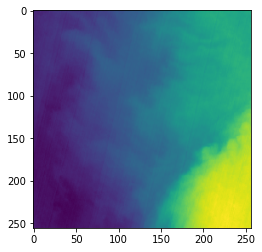

In [14]:
from matplotlib import pyplot as plt

plt.imshow(test_img[0,:,:,4])

In [15]:
test_pred = model.predict(test_img)

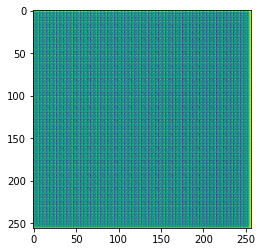

In [17]:
plt.imshow(test_pred[-1][0,:,:,0])

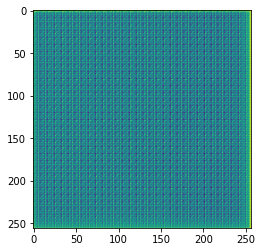

In [18]:
plt.imshow(test_pred[-1][0,:,:,1])